In [1]:
import datetime as dt
import pandas as pd
import numpy as np

from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import yfinance as yf

[*********************100%***********************]  1 of 1 completed


(0.1128184737066513, 102.12999725341797)

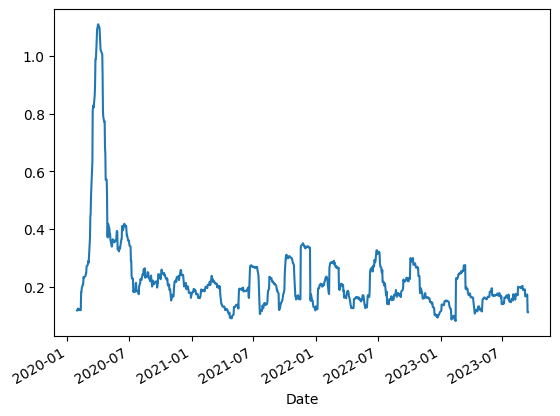

In [2]:
end = dt.datetime.now()
start = dt.datetime(2020,1,1)

# df = pdr.get_data_yahoo(['CBA.AX'], start, end)
df = yf.download(['CBA.AX'], start, end)
Close = df.Close
Close.tail()

log_returns = np.log(df.Close/df.Close.shift(1)).dropna()
# log_returns
TRADING_DAYS = 20
volatility = log_returns.rolling(window=TRADING_DAYS).std()*np.sqrt(252)

volatility.plot()
volatility.iloc[-1], Close.iloc[-1]

# Implied Volatility

In [3]:
from py_vollib.black_scholes.implied_volatility import implied_volatility as iv
from py_vollib.black_scholes import black_scholes as bs
from py_vollib.black_scholes.greeks.analytical import vega, delta

def implied_vol(S0, K, T, r, market_price, flag='c', tol=0.00001):
    """Calculating the implied volatility of an European option
        S0: stock price
        K: strike price
        T: time to maturity
        r: risk-free rate
        market_price: option price in market
    """
    max_iter = 200 #max no. of iterations
    vol_old = 0.1 #initial guess 

    for k in range(max_iter):
        bs_price = bs(flag, S0, K, T, r, vol_old)
        Cprime = vega(flag, S0, K, T, r, vol_old)*100
        C = bs_price - market_price

        vol_new = vol_old - C/Cprime
        new_bs_price = bs(flag, S0, K, T, r, vol_new)
        if (abs(vol_old-vol_new) < tol or abs(new_bs_price-market_price) < tol):
            break

        vol_old = vol_new

    implied_vol = vol_new
    return implied_vol

In [4]:
S0 = 102
atm_options = [
[dt.date(2021,10,18),102,[2.585,3.25],[4.600,5.300]],
]
call_bids,call_asks,put_bids,put_asks, = [],[],[],[]
IV_DTE = []

for i in atm_options:
    date, K = i[0], i[1]
    DTE = (date - dt.date(2021,7,30)).days
    T = DTE/365
    r = 0.02
    call_bid, call_ask = i[2]
    put_bid, put_ask = i[3] 

    call_bids.append(implied_vol(S0, K, T, r, call_bid, flag='c')*100)
    call_asks.append(implied_vol(S0, K, T, r, call_ask, flag='c')*100)
    put_bids.append(implied_vol(S0, K, T, r, put_bid, flag='p')*100)
    put_asks.append(implied_vol(S0, K, T, r, put_ask, flag='p')*100)
    IV_DTE.append(DTE)

call_bids,call_asks,put_bids,put_asks

([12.391744243113061],
 [15.89983054184741],
 [25.370308271406177],
 [29.062481076021502])

In [5]:
K = 102
N = 11 # 11 weeks
sigma = 0.30
S0 = 102
DTE = (dt.date(2021,10,18) - dt.date(2021,7,30)).days
T = DTE/365
r = 0.02
DT = T/N
TTE = [DT*N-DT*i for i in range(0,N+1)]

In [6]:
# Create functions to appply to pandas dataframes to calculate specific adjustments to be made during delta hedging.

In [7]:
def calc_delta(flag, price, K, time, r, sigma, position='s'):
    if time == 0:
        return np.nan
    else:
        if position=='l':
            return int(delta(flag, price, K, time, r, sigma)*100)
        else:
            return -int(delta(flag, price, K, time, r, sigma)*100)
        
def adjust(delta, total):
    if delta < 0:
        return 'Buy {0}'.format(abs(delta))
    elif delta > 0:
        return 'Sell {0}'.format(abs(delta))
    elif delta == 0:
        return 'None'
    else:
        if total < 0:
            return 'Sell {0}'.format(abs(total))
        elif total > 0:
            return 'Buy {0}'.format(abs(total))
        else:
            return np.nan

def totalAdj(counter,time):
    if time > 0:
        if counter < 0:
            return 'Long {0}'.format(abs(counter))
        elif counter > 0:
            return 'Short {0}'.format(abs(counter))
        else:
            return np.nan
    else:
            return np.nan
        
def cashAdj(delta, price, time, total):
    if time > 0:
        return delta*price
    else:
        return -total*price

In [8]:
# Create Dynamic Hedging results dataframe to append rows to.

In [9]:
Dynamic_Hedging_Results = pd.DataFrame(data=[], columns=[], index=['Original Option P&L','Original Stock P&L','Adjustment P&L', \
                                                                             'Carry (interest) on options', 'Carry (interest) on stock', \
                                                                             'Interest on Adjustments'])
Dynamic_Hedging_Results.index.name = 'Dynamic hedging results'

call_bid,call_ask,put_bid,put_ask = 2.585,3.25,4.600,5.300

# number of sims
M = 1000

# Realized Volatility
sigma = 0.12

# Position in Option contract
k = 102
position = 's'
flag = 'c'

In [10]:
# Create simulations of underlying stock prices using Geometric Brownian Motion (GBM) over time.

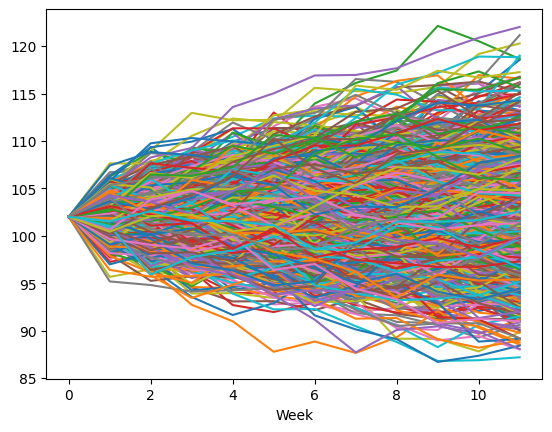

,Time,0,1,2,3,4,5,6,7,8,...,990,991,992,993,994,995,996,997,998,999
Week,,,,,,,,,,,,,,,,,,,,,
0,0.22,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,...,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00
1,0.20,101.23,102.06,103.16,101.28,99.07,102.45,105.49,104.10,102.75,...,103.61,104.60,102.79,103.12,104.25,100.21,100.63,103.94,100.43,101.52
2,0.18,101.88,104.35,103.29,99.69,97.91,99.70,103.61,103.66,106.45,...,102.79,102.38,101.89,102.25,103.57,102.93,103.83,100.71,102.07,102.59
3,0.16,98.80,105.93,102.60,99.48,95.53,99.74,106.75,106.19,101.79,...,103.98,102.11,102.94,101.33,102.29,104.30,104.71,100.08,102.22,101.61
4,0.14,97.19,106.45,103.23,103.23,96.51,101.26,104.87,105.53,101.59,...,106.27,100.54,104.65,98.61,104.71,106.32,103.31,100.12,100.47,101.52
5,0.12,99.19,104.25,101.59,105.58,96.81,101.67,106.88,102.62,102.29,...,105.32,98.31,104.99,100.79,106.74,110.24,103.67,98.60,101.00,101.11
6,0.10,101.58,102.90,100.53,104.86,97.66,101.26,107.68,100.88,101.32,...,102.24,97.55,108.65,97.74,103.79,107.10,104.13,98.67,103.09,98.59
7,0.08,102.81,100.33,98.93,107.71,100.10,99.91,109.11,102.40,100.62,...,103.07,96.22,110.23,98.53,100.81,105.49,102.23,101.05,105.36,99.30
8,0.06,101.28,101.10,96.31,107.39,98.36,98.36,111.10,104.76,101.78,...,103.02,93.48,110.71,98.80,99.56,108.62,101.41,101.79,107.23,101.49


In [11]:
nudt = (r - 0.5*sigma**2) * DT
sigmasdt = sigma*np.sqrt(DT)

no_hedge = []
static_hedge = []

# number of sims

St = S0
St_series = [np.array([St for m in range(M)])]
for i in range(N):
    St = St_series[-1]
    Stn = np.round( St * np.exp(nudt + sigmasdt*np.random.normal(0,1,M)) , 2)
    St_series.append(Stn)
    
St_series = np.array(St_series)

df = pd.DataFrame(St_series, columns = [i for i in range(M)])
df.index.name = 'Week'
df.plot()
plt.legend().set_visible(False)
plt.show()
df.insert(0, "Time", np.round(TTE,2))
df# Create simulations of underlying stock prices using Geometric Brownian Motion (GBM) over time.

# Build up delta hedging dataframe with specific factors: 

In [12]:
# 1. delta
# 2. total delta positions 
# 3. number of adjustments 
# 4. adjustment cashflow 
# 5. interest on adjustments
# We can then sum the columns over the 11 weeks of delta heding and 
# calculate the carry on options, carry on stock, option p&l, stock p&l and adjustment p&l and interest earned on adjustments.

In [13]:
for sim in range(M):
    hedgeSim = df.loc[:,['Time',sim]]
    hedgeSim.columns = ['Time', 'Price']
    
    # hedge calcs
    hedgeSim['delta'] = hedgeSim.apply(lambda x: calc_delta(flag, x['Price'], K, x['Time'], r, sigma, position), axis=1)
    hedgeSim['Total Delta Position'] = (hedgeSim.delta - hedgeSim.delta.shift(1))
    totaladjust_c = [hedgeSim['Total Delta Position'][:i].sum() for i in range(1,N+1)]
    hedgeSim['totaladjust_c'] = [hedgeSim['Total Delta Position'][:i].sum() for i in range(1,N+2)]
    hedgeSim['Adjustment Contracts'] = hedgeSim.apply(lambda x: adjust(x['Total Delta Position'], x['totaladjust_c']), axis=1)
    hedgeSim['Total Adjustment'] = hedgeSim.apply(lambda x: totalAdj(x['totaladjust_c'],x['Time']), axis=1)
    hedgeSim['totaladjust_c'] = [hedgeSim['Total Delta Position'][:i].sum() for i in range(1,N+2)]
    hedgeSim['Adjustment Cashflow'] = hedgeSim.apply(lambda x: cashAdj(x['Total Delta Position'],x['Price'],x['Time'], x['totaladjust_c']), axis=1)
    hedgeSim['Interest on Adjustments'] = hedgeSim.apply(lambda x: round(x['Adjustment Cashflow']*r*x['Time'],2), axis=1)
    hedgeSim = hedgeSim.drop(columns=['totaladjust_c'])
    
    # calculate payoffs
    if flag == 'c':
        if position == 's':
            optprice = call_bid
            option_pnl = 100*(optprice - np.maximum(hedgeSim.loc[11,'Price']-K,0))
            # delta will be negative if short
            stock_pnl = hedgeSim.loc[0,'delta']*(S0 - hedgeSim.loc[11,'Price'])
            adj_pnl = hedgeSim['Adjustment Cashflow'].sum()
            option_carry = 100*optprice*r*T
            # delta will be negative if short
            stock_carry = hedgeSim.loc[0,'delta']*S0*r*T
            int_adj_pnl = hedgeSim['Interest on Adjustments'].sum()
        else:
            optprice = call_ask
            option_pnl = 100*(np.maximum(hedgeSim.loc[11,'Price']-K,0) - optprice)
            # delta will be positive if long
            stock_pnl = hedgeSim.loc[0,'delta']*(S0 - hedgeSim.loc[11,'Price'])
            adj_pnl = hedgeSim['Adjustment Cashflow'].sum()
            option_carry = -100*optprice*r*T
            # delta will be positive if long
            stock_carry = hedgeSim.loc[0,'delta']*S0*r*T
            int_adj_pnl = hedgeSim['Interest on Adjustments'].sum()
            
    elif flag == 'p':
        if position == 's':
            optprice = put_bid
            option_pnl = 100*(optprice - np.maximum(K-hedgeSim.loc[11,'Price'],0))
            # delta will be positive if short
            stock_pnl = hedgeSim.loc[0,'delta']*(S0 - hedgeSim.loc[11,'Price'])
            adj_pnl = hedgeSim['Adjustment Cashflow'].sum()
            option_carry = 100*optprice*r*T
            # delta will be positive if short
            stock_carry = hedgeSim.loc[0,'delta']*S0*r*T
            int_adj_pnl = hedgeSim['Interest on Adjustments'].sum()
        else:
            optprice = put_ask
            option_pnl = 100*(np.maximum(K-hedgeSim.loc[11,'Price'],0) - optprice)
            # delta will be negative if long
            stock_pnl = hedgeSim.loc[0,'delta']*(S0 - hedgeSim.loc[11,'Price'])
            adj_pnl = hedgeSim['Adjustment Cashflow'].sum()
            option_carry = -100*optprice*r*T
            # delta will be negative if long
            stock_carry = hedgeSim.loc[0,'delta']*S0*r*T
            int_adj_pnl = hedgeSim['Interest on Adjustments'].sum()
        
    data=[option_pnl,stock_pnl,adj_pnl,option_carry,stock_carry,int_adj_pnl]

    #add to dataframe
    Dynamic_sim = pd.DataFrame(data=data, columns=[sim], index=['Original Option P&L','Original Stock P&L','Adjustment P&L', \
                                                                             'Carry (interest) on options', 'Carry (interest) on stock', \
                                                                             'Interest on Adjustments'])
    Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
    no_hedge.append(option_pnl+option_carry)
    static_hedge.append(option_pnl+option_carry+stock_pnl+stock_carry)

C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Conside

C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Conside

C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Conside

C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Conside

C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Conside

C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Conside

C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Conside

C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Conside

C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Conside

C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Conside

C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Conside

C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Conside

C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Conside

C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Conside

C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Conside

C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Conside

C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Conside

C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Conside

C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Conside

C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Conside

C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Conside

C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Conside

C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Conside

C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Conside

C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Conside

C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Conside

C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Conside

C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Conside

C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Conside

C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Conside

C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Conside

C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Conside

C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Conside

C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Conside

C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Conside

C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
C:\Users\hp\AppData\Local\Temp\ipykernel_8156\1396501150.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Conside

# Delta Hedging P&L 

In [14]:
# Sum all contributions for Total Cashflow for each simulation

In [15]:
Dynamic_Hedging_Results.loc['TOTAL CASHFLOW',] = Dynamic_Hedging_Results.sum(axis=0)
Dynamic_Hedging_Results

IndexError: tuple index out of range

# Visualise distributions

In [27]:
# 1. hedging
# 2. static hedge (at entry only)
# 3. no delta heding

C:\Users\hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\axes\_axes.py:6763: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
C:\Users\hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\axes\_axes.py:6764: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

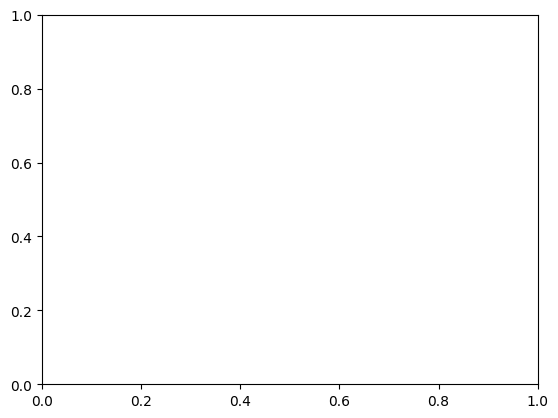

In [28]:
x = Dynamic_Hedging_Results.loc['TOTAL CASHFLOW',]
plt.hist(x, density=True, bins=30)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('P&L');
x.mean(),np.percentile(x,5)
plt.title('Dynamic Delta Hedging')
plt.axvline(x.mean(), color='k', linestyle='dashed', linewidth=3)
plt.axvline(np.percentile(x,5), color='r', linestyle='dashed', linewidth=3)
plt.axvline(np.percentile(x,95), color='b', linestyle='dashed', linewidth=3)
min_ylim, max_ylim = plt.ylim()

if position == 's':
    plt.text(np.percentile(x,0), max_ylim*0.9, 'P95:  {:.2f}'.format(np.percentile(x,95))).set_color('blue')
    plt.text(np.percentile(x,0), max_ylim*0.8, 'Mean: {:.2f}'.format(x.mean()))
    plt.text(np.percentile(x,0), max_ylim*0.7, 'P5:   {:.2f}'.format(np.percentile(x,5))).set_color('red')
elif position == 'l':
    plt.text(np.percentile(x,99), max_ylim*0.9, 'P95:  {:.2f}'.format(np.percentile(x,95))).set_color('blue')
    plt.text(np.percentile(x,99), max_ylim*0.8, 'Mean: {:.2f}'.format(x.mean()))
    plt.text(np.percentile(x,99), max_ylim*0.7, 'P5:   {:.2f}'.format(np.percentile(x,5))).set_color('red')

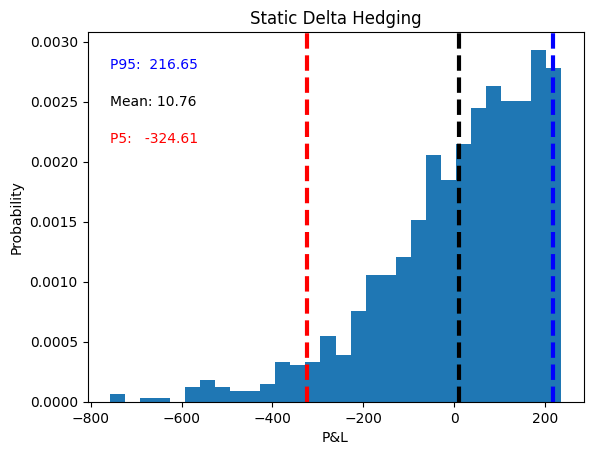

In [29]:
x = np.array(static_hedge)
plt.hist(x, density=True, bins=30)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('P&L');
x.mean(),np.percentile(x,5)
plt.title('Static Delta Hedging')
plt.axvline(x.mean(), color='k', linestyle='dashed', linewidth=3)
plt.axvline(np.percentile(x,5), color='r', linestyle='dashed', linewidth=3)
plt.axvline(np.percentile(x,95), color='b', linestyle='dashed', linewidth=3)
min_ylim, max_ylim = plt.ylim()
if position == 's':
    plt.text(np.percentile(x,0), max_ylim*0.9, 'P95:  {:.2f}'.format(np.percentile(x,95))).set_color('blue')
    plt.text(np.percentile(x,0), max_ylim*0.8, 'Mean: {:.2f}'.format(x.mean()))
    plt.text(np.percentile(x,0), max_ylim*0.7, 'P5:   {:.2f}'.format(np.percentile(x,5))).set_color('red')
elif position == 'l':
    plt.text(np.percentile(x,99), max_ylim*0.9, 'P95:  {:.2f}'.format(np.percentile(x,95))).set_color('blue')
    plt.text(np.percentile(x,99), max_ylim*0.8, 'Mean: {:.2f}'.format(x.mean()))
    plt.text(np.percentile(x,99), max_ylim*0.7, 'P5:   {:.2f}'.format(np.percentile(x,5))).set_color('red')

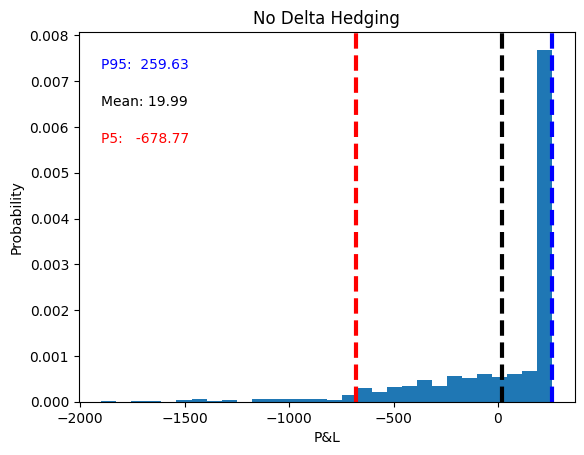

In [30]:
x = np.array(no_hedge)
plt.hist(x, density=True, bins=30)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('P&L');
x.mean(),np.percentile(x,5)
plt.title('No Delta Hedging')
plt.axvline(x.mean(), color='k', linestyle='dashed', linewidth=3)
plt.axvline(np.percentile(x,5), color='r', linestyle='dashed', linewidth=3)
plt.axvline(np.percentile(x,95), color='b', linestyle='dashed', linewidth=3)
min_ylim, max_ylim = plt.ylim()
if position == 's':
    plt.text(np.percentile(x,0), max_ylim*0.9, 'P95:  {:.2f}'.format(np.percentile(x,95))).set_color('blue')
    plt.text(np.percentile(x,0), max_ylim*0.8, 'Mean: {:.2f}'.format(x.mean()))
    plt.text(np.percentile(x,0), max_ylim*0.7, 'P5:   {:.2f}'.format(np.percentile(x,5))).set_color('red')
elif position == 'l':
    plt.text(np.percentile(x,99), max_ylim*0.9, 'P95:  {:.2f}'.format(np.percentile(x,95))).set_color('blue')
    plt.text(np.percentile(x,99), max_ylim*0.8, 'Mean: {:.2f}'.format(x.mean()))
    plt.text(np.percentile(x,99), max_ylim*0.7, 'P5:   {:.2f}'.format(np.percentile(x,5))).set_color('red')